In [244]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)

In [245]:
torch.manual_seed(42)
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [246]:
# cleaning the dataframe
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
display(df)

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [247]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for findings in df["Finding Labels"].unique():
    for disease_label in findings.split("|"):
        diseases.add(disease_label)
print(diseases)
for d in diseases:
    df[d]=0
for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
display(df)

{'Fibrosis', 'Atelectasis', 'Hernia', 'Pleural_Thickening', 'Mass', 'Consolidation', 'Edema', 'No Finding', 'Effusion', 'Cardiomegaly', 'Infiltration', 'Pneumonia', 'Nodule', 'Pneumothorax', 'Emphysema'}


,Image Index,Fibrosis,Atelectasis,Hernia,Pleural_Thickening,Mass,Consolidation,Edema,No Finding,Effusion,Cardiomegaly,Infiltration,Pneumonia,Nodule,Pneumothorax,Emphysema
0,00000001_000.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,00000001_001.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,00000001_002.png,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,00000003_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


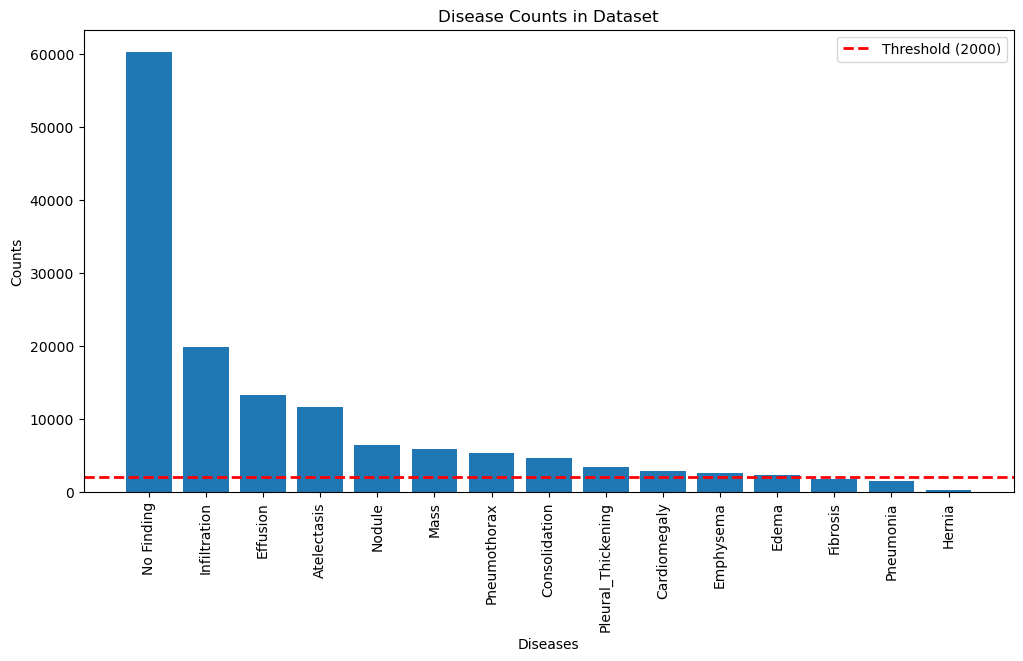

In [253]:
counts=[df[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [6]:
# # we now create the training data frame using the list provided in the files.
# image_names_train= open(r"train_val_list.txt").read().split("\n")
# for i in image_names_train:
#     df_train=df[df["Image Index"].isin(image_names_train)]
# df_train.to_parquet("df_train.parquet")

In [7]:
# # we now create the training data frame using the list provided in the files.
# image_names_test= open(r"test_list.txt").read().split("\n")
# for i in image_names_test:
#     df_test=df[df["Image Index"].isin(image_names_test)]
# df_test.to_parquet("df_test.parquet")

In [254]:
df_train=pd.read_parquet("df_train.parquet")

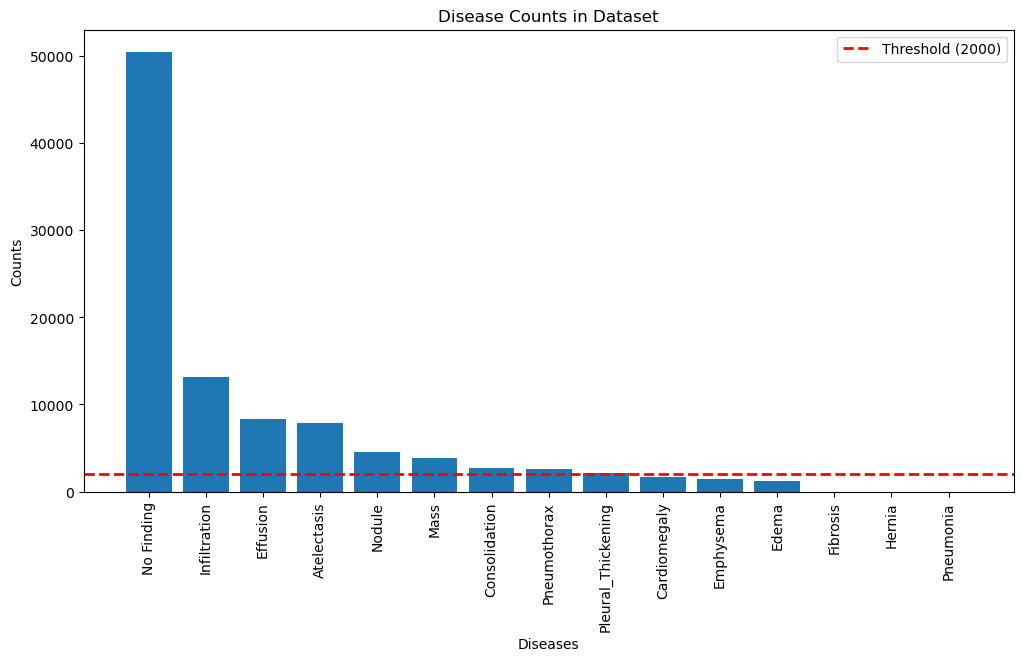

In [255]:
# We check to see how balanced the set is and check if any class is very underrepresented.
diseases=list(diseases)
counts=[df_train[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [258]:
# we remove diseases that are too rare.
rare_diseases=[d[0] for d in disease_counts if d[1]<2000]
print("Rare Diseases ( <2000 images ): ", rare_diseases)
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]


Rare Diseases ( <2000 images ):  ['Cardiomegaly', 'Emphysema', 'Edema', 'Fibrosis', 'Hernia', 'Pneumonia']


In [259]:
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]

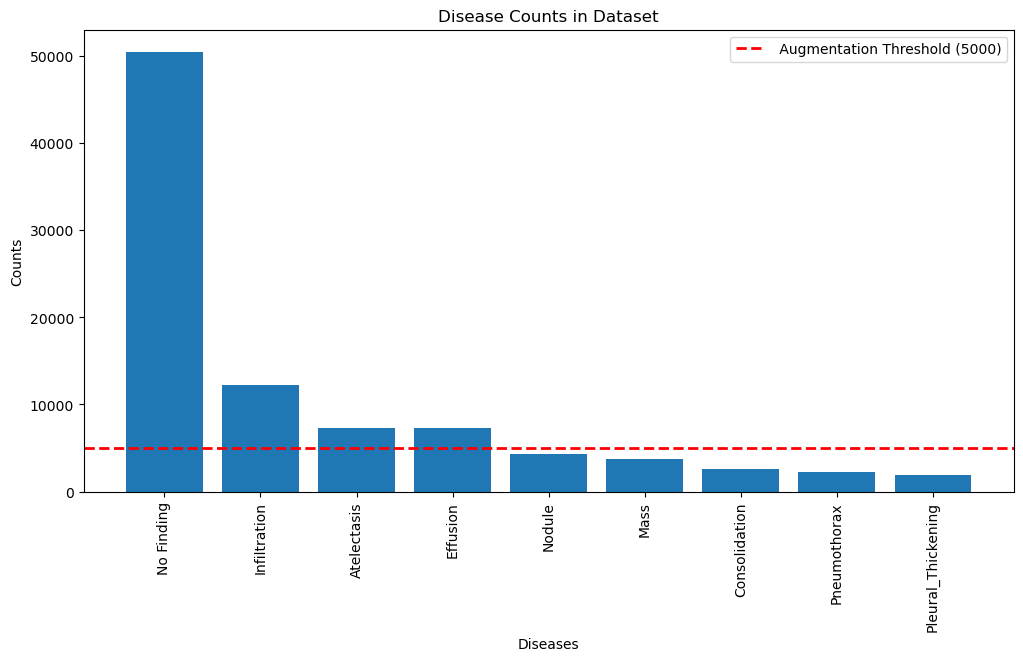

In [260]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train[i].sum() for i in common_diseases if i in df_train.columns]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [261]:
df_train=df_train.drop(columns=["No Finding"])

In [262]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [ ]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [240]:

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True)

In [ ]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Model setup (DenseNet example)
num_classes = 8
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout to reduce overfitting
    nn.Linear(512, num_classes)  # Final layer for multi-label classification
)
model = model.to(device)

# Loss function and optimizer
pos_weight = (df_train.iloc[:,1:]==0.).sum()/df_train.iloc[:,1:].sum()
class_weights=torch.tensor(pos_weight.values,dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
# Create the trainer and evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "precision": Precision(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "recall": Recall(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

# Validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

In [266]:
trainer.run(train_loader, max_epochs=9)

[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 3  Avg accuracy: 0.2370  Avg loss: 1.2098
Learning Rate after Epoch 3: 0.001000
Scheduler stepped with validation loss: 1.2098


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 4  Avg accuracy: 0.3279  Avg loss: 1.1873
Learning Rate after Epoch 4: 0.001000
Scheduler stepped with validation loss: 1.1873


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 5  Avg accuracy: 0.3017  Avg loss: 1.1838
Learning Rate after Epoch 5: 0.001000
Scheduler stepped with validation loss: 1.1838


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 6  Avg accuracy: 0.2260  Avg loss: 1.1713
Learning Rate after Epoch 6: 0.001000
Scheduler stepped with validation loss: 1.1713


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 7  Avg accuracy: 0.1967  Avg loss: 1.1694
Learning Rate after Epoch 7: 0.001000
Scheduler stepped with validation loss: 1.1694


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 8  Avg accuracy: 0.1197  Avg loss: 1.1695
Learning Rate after Epoch 8: 0.001000
Scheduler stepped with validation loss: 1.1695


[1/4005]   0%|           [00:00<?]


Validation Results - Epoch: 9  Avg accuracy: 0.1295  Avg loss: 1.1764
Learning Rate after Epoch 9: 0.001000
Scheduler stepped with validation loss: 1.1764


State:
	iteration: 36045
	epoch: 9
	epoch_length: 4005
	max_epochs: 9
	output: 0.892690861866308
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [263]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
df_test=df_test.drop(columns="No Finding")
df_test

,Image Index,Atelectasis,Pleural_Thickening,Mass,Consolidation,Effusion,Infiltration,Nodule,Pneumothorax
38,00000013_000.png,0,0,0,0,0,0,0,0
39,00000013_001.png,0,0,0,0,0,0,0,1
40,00000013_002.png,0,0,0,0,0,0,0,1
41,00000013_003.png,0,1,0,0,0,0,0,0
42,00000013_004.png,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,0,0,0,0,0,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0


In [267]:
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label  = label.to(device)
        outputs = model(images)

        # Store predictions & labels
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())

    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

State:
	iteration: 767
	epoch: 1
	epoch_length: 767
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>


Classification Report (Per-Class):
              precision    recall  f1-score   support

     Class 0       0.16      0.83      0.27      3150
     Class 1       0.06      0.74      0.11      1060
     Class 2       0.08      0.68      0.15      1667
     Class 3       0.09      0.90      0.17      1724
     Class 4       0.24      0.90      0.38      4501
     Class 5       0.27      0.87      0.41      5759
     Class 6       0.08      0.63      0.13      1544
     Class 7       0.13      0.92      0.22      2590

   micro avg       0.14      0.84      0.25     21995
   macro avg       0.14      0.81      0.23     21995
weighted avg       0.18      0.84      0.29     21995
 samples avg       0.13      0.47      0.19     21995


Confusion Matrix:
 [[10066  1741    48   198     0   724   768   351]
 [  645   172     1     7     0    17    21    14]
 [  923   235     4     7     0    30    55    25]
 [  926    76     0    18     0    27    19     9]
 [ 2261   242     1    36     0    

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


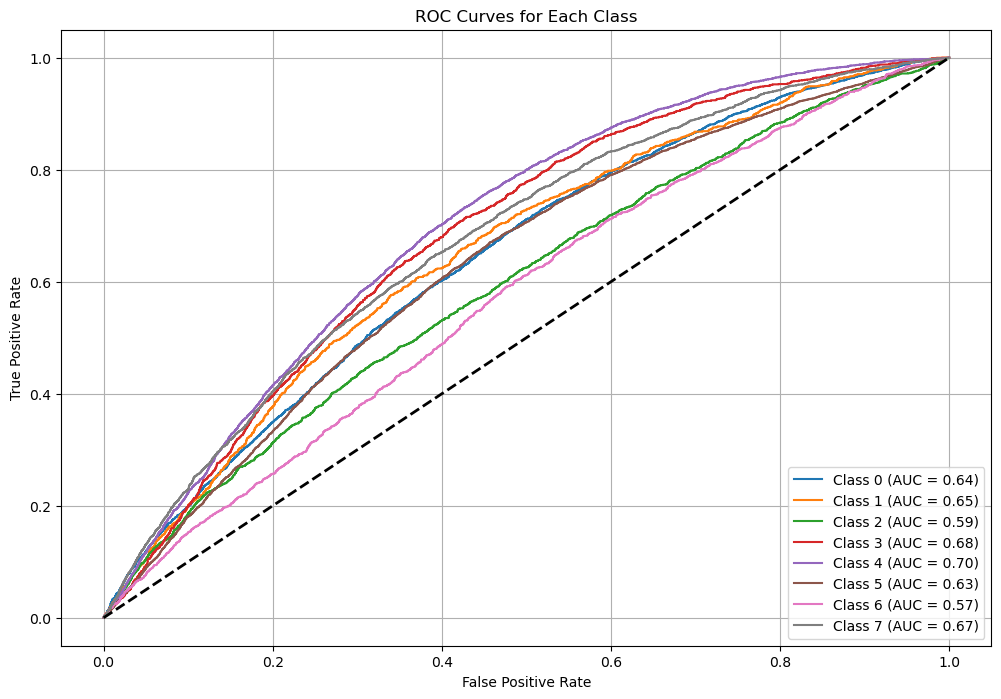

In [268]:
# Convert lists to arrays
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
preds = (probs > 0.5).astype(int)

# %% [markdown]
# ## Metrics on Test Set

y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[f"Class {i}" for i in range(y_true.shape[1])]
    )
)

# Confusion matrix (argmax at the row level can be misleading for multi-label,
# but shown here for demonstration.)
cm = confusion_matrix(
    y_true.argmax(axis=1), 
    y_pred.argmax(axis=1)
)
print("\nConfusion Matrix:\n", cm)

# Element-wise binary accuracy
correct_predictions = (y_true == y_pred).sum()
total_predictions   = y_true.size
binary_accuracy     = correct_predictions / total_predictions
print(f"Binary Accuracy: {binary_accuracy:.4f}")

# %% [markdown]
# ## ROC Curves (Optional)

plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [269]:
torch.save(model.state_dict(),"Model, Epochs of 10 with dropout and class-weights")